In [1]:
%matplotlib inline
import data
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
idd, seq = data.readseq('train.csv')

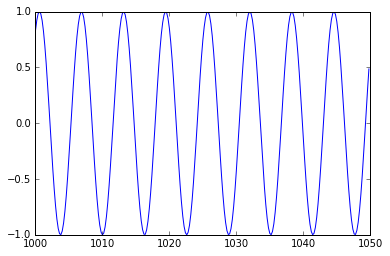

In [22]:
x = np.arange(1000, 1050, step=0.2)
y = np.sin(x)
plt.plot(x, y)
plt.show()

In [23]:
def get_batch(s, ix):
    t = s[ix]
    return t[:-1], t[1:]
def sine_data(ix,size=50):
    x = np.arange(ix, ix + size, step = 0.2)
    y = np.sin(x)
    return y[:-1], y[1:]

In [24]:
inp_out_size = 1
hidden_layer_size = 5
lr = 0.001
epoch = 7000
print_step = 200
num_steps = 15

In [25]:
# zoneout as in https://arxiv.org/pdf/1606.01305v1.pdf
def zoneout(h, h_prev):
    assert h.get_shape() == h_prev.get_shape()
    r = tf.select(tf.random_uniform(h.get_shape()) > keep, tf.ones_like(h), tf.zeros_like(h))
    h_z = tf.mul(r, h_prev) + tf.mul(tf.sub(tf.ones_like(r), r), h)
    return h_z

In [57]:
tf.reset_default_graph()
initializer = tf.random_uniform_initializer(minval=-0.01, maxval=0.01, dtype=tf.float32)
Wxh = tf.get_variable('Wxh', shape=[inp_out_size, hidden_layer_size], initializer=initializer)
Whh = tf.get_variable('Whh', shape=[hidden_layer_size, hidden_layer_size], initializer=initializer)
Why = tf.get_variable('Why',shape=[hidden_layer_size, inp_out_size], initializer=initializer)
# weights associated with update gate
Wxz = tf.get_variable('Wxz', shape=[inp_out_size, hidden_layer_size], initializer=initializer)
Whz = tf.get_variable('Whz', shape=[hidden_layer_size, hidden_layer_size], initializer=initializer)
# weights associated with the reset gate
Wxr = tf.get_variable('Wxr', shape=[inp_out_size, hidden_layer_size], initializer=initializer)
Whr = tf.get_variable('Whr', shape=[hidden_layer_size, hidden_layer_size], initializer=initializer)

In [59]:
def GRU(prev, inp):
    i = tf.reshape(inp, shape=[1, -1])
    p = tf.reshape(prev, shape=[1, -1])
    z = tf.nn.sigmoid(tf.matmul(i, Wxz) + tf.matmul(p, Whz))    # update gate
    r = tf.nn.sigmoid(tf.matmul(i, Wxr) + tf.matmul(p, Whr))    # reset gate
    h_ = tf.nn.tanh(tf.matmul(i, Wxh) + tf.matmul(tf.mul(p, r), Whh))
    h = tf.mul(tf.sub(tf.ones_like(z), z), h_) + tf.mul(z, p)
    h = zoneout(h, p)
    return tf.reshape(h, [hidden_layer_size])

In [60]:
# model
inputs = tf.placeholder(shape=[None, 1], dtype=tf.float32)
targets = tf.placeholder(shape=[None, 1], dtype=tf.float32)
keep = tf.placeholder(dtype=tf.float32)
initial = tf.placeholder(shape=[hidden_layer_size], dtype=tf.float32)
hiddens = tf.scan(GRU, inputs, initializer=initial)
outputs = tf.matmul(hiddens, Why)
loss = tf.sqrt(tf.reduce_sum(tf.square(tf.sub(outputs, targets))))
optimizer = tf.train.GradientDescentOptimizer(lr)
optimize_op = optimizer.minimize(loss)

In [61]:
sess = tf.Session()
sess.run(tf.initialize_all_variables())

In [62]:
ix = 0
ini = np.zeros([hidden_layer_size])

In [63]:
for i in range(epoch):
    a, b = sine_data(ix, size=num_steps)    
    a = np.reshape(a, [-1, 1])
    b = np.reshape(b, [-1, 1])
    l, h, _ = sess.run([loss, hiddens, optimize_op], {inputs: a, targets: b, initial: ini, keep: 0.7})
    ix += 1
    if i % print_step == 0:
        print('Loss', l)
    ix += num_steps
    ini = h[-1]

Loss 6.20545
Loss 5.91637
Loss 6.21059
Loss 5.88766
Loss 5.43061
Loss 3.94114
Loss 3.15919
Loss 3.06633
Loss 2.6858
Loss 2.58131
Loss 2.63796
Loss 2.54896
Loss 2.40207
Loss 2.15102
Loss 2.60406
Loss 1.92682
Loss 1.97965
Loss 1.89547
Loss 1.4631
Loss 1.16086
Loss 0.908506
Loss 0.826549
Loss 0.66401
Loss 0.742195
Loss 0.893758
Loss 0.624306
Loss 0.650081
Loss 0.639659
Loss 0.871191
Loss 1.07262
Loss 0.763835
Loss 0.575472
Loss 0.478095
Loss 0.609758
Loss 0.541901


In [64]:
def generate(sess, n):
    ix = [[0.2]]
    v = []
    h = np.zeros(hidden_layer_size)
    for i in range(n):
        o, h = sess.run([outputs, hiddens], {inputs:ix, initial: h, keep: 1.0})
        h = h.reshape(hidden_layer_size)
        ix = o
        v.append(np.squeeze(o))
    return v

(224,) (250,)


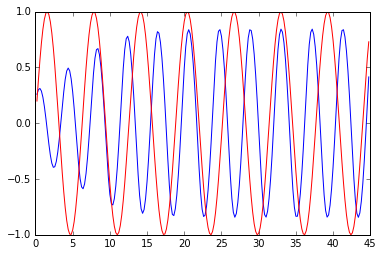

In [65]:
x = np.arange(0.2, 45, step = 0.2)
pred = np.array(generate(sess, len(x)))
true = np.sin(x)
print(x.shape, y.shape)
plt.plot(x, pred, 'b-')
plt.plot(x, true, 'r-')
plt.show()